In [1]:
import sys
import os
# Add the directory containing 'thesis_utils.py' to the system path
sys.path.append(os.path.abspath('..'))  # If 'thesis_utils.py' is one level up
# Or use this if it's in the same directory as the notebook:
# sys.path.append(os.getcwd())
# os.environ["JULIA_NUM_THREADS"] = "8" 
os.environ["PYTHON_JULIACALL_HANDLE_SIGNALS"] = "yes"
os.environ["PYTHON_JULIACALL_THREADS"] = "auto"
os.environ["PYTHON_JULIACALL_OPTLEVEL"] = "3"
from pysr import PySRRegressor
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

from thesis_utils import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [22]:
import importlib
import thesis_utils  # or whatever your module is called

importlib.reload(thesis_utils)

from thesis_utils import *

In [2]:
data = pd.read_csv("C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/real_estate/real_estate_valuation_cleaned.csv")

In [3]:
# Generate the profiling report
profile_full = ProfileReport(data, title="real_estate_valuation_cleaned", explorative=True)

# Get the description object
desc_full = profile_full.get_description()

# Access the correlation matrix
correlation_matrix = desc_full.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
categorical_cols = get_categorical_columns(data)
distributions = fit_distributions(data)
marginals = convert_distfit_to_marginals(distributions, data)

In [5]:
data_syn = generate_synthetic_dataset(original_data=data, correlation_matrix=correlation_matrix, categorical_columns=categorical_cols, marginals=marginals, n_rows=500, correlation_threshold=0.1, edge_strategy="random", sampling_strategy="local-chunks")

In [6]:
# Generate the profiling report
profile_syn = ProfileReport(data_syn, title="real_estate_valuation_cleaned SYN", explorative=True)

# Get the description object
desc_syn = profile_syn.get_description()

# Access the correlation matrix
correlation_matrix_syn = desc_syn.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
plot_correlation_matrices(correlation_matrix, correlation_matrix_syn, "Real", "Synthetic")

In [8]:
from sdmetrics.reports.single_table import QualityReport

data_syn = data_syn[data.columns.to_list()]

metadata = {
    "columns": {
        "X1 house age": {"sdtype": "numerical"},
        "X2 distance MRT station": {"sdtype": "numerical"},
        "X3 number convenience stores": {"sdtype": "numerical"},
        "X4 lat": {"sdtype": "numerical"},
        "X5 long": {"sdtype": "numerical"},
        "X6 price": {"sdtype": "numerical"}
    }
}

report = QualityReport()
report.generate(data, data_syn, metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 6/6 [00:00<00:00, 998.56it/s]|
Column Shapes Score: 88.45%

(2/2) Evaluating Column Pair Trends: |██████████| 15/15 [00:00<00:00, 257.72it/s]|
Column Pair Trends Score: 93.12%

Overall Score (Average): 90.79%



In [11]:
# variable assignment according to correlation structure
independents_lst = ['X2 distance MRT station', 'X3 number convenience stores', 'X4 lat']
dependent_var = 'X6 price'
X = data_syn[independents_lst].to_numpy()
y = data_syn[dependent_var].to_numpy()

In [12]:
sr_model = PySRRegressor(
        niterations=1024,  # Number of iterations to search for equations
        binary_operators=["+", "-", "*", "/"],
        unary_operators=["sin", "cos", "exp", "log", "abs", "sqrt"],
        elementwise_loss="loss(x, y) = (x - y)^2",  # Define loss function (mean squared error)
        verbosity=0,
        maxsize=50
    )
sr_model.fit(X, y)

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                          37.620506   
	1         6.052428e-02                                    x1 - -33.221508   
	2         2.678537e-01                               64.760345 - sqrt(x0)   
	3         1.330487e-01                           abs(sqrt(x0) - 63.50413)   
	4   >>>>  2.526792e-01                   (log(x0) * -8.999874) + 94.51521   
	5         4.558852e-03           ((x2 - log(x0)) * 8.993731) + -130.08406   
	6         2.695379e-02      ((x2 - sqrt(log(x0))) * 44.191505) - 955.0874   
	7         1.492099e-01  ((-24.710472 - (log(x0) * 0.022819163)) + x2) ...   
	8         1.549189e-03  (log(x0 + 34.23155) * -8.241254) - ((x2 + -24....   
	9         7.542471e-08  ((log(x0 + 34.23378) * -8.1092825) - ((x2 + -2...   
	10        2.101427e-03  (log(x0 + 33.626595) * -8.239526) - ((x2 + -24...   
	11        3.639246e-04  ((log(x0 + 34.231117) * -8.220968) - ((x2 + -2...   
	12        1.707914e-02  (((log(x0) * 0.023251304) - (x2 + -24.706154))...   
	13        1.410887e-03  (((log(x0 + x2) * 0.024883026) - (x2 + -24.694...   
	14        1.150841e-03  (((log(x0 + x2) * 0.024883026) - (x2 + -24.694...   
	15        5.691682e-05  abs((((log((x2 + sin(x0)) + x0) * -8.214815) -...   
	16        4.004638e-03  (((x2 + sin(x2)) - 24.532694) * (798.2994 * sq...   
	17        5.231387e-03  sin(x0 * 170.73015) + (sin(x0 * -0.39917558) +...   
	18        6.250671e-08  abs((sin(170.73015 * x0) + (sin(x0 * -0.399175...   
	19        1.147437e-03  (((sqrt(sqrt(x0) / (x0 + 54.48666)) * ((x2 + s...   
	20        1.326495e-03  ((sqrt(sqrt(x0) / (x0 + 54.486675)) * ((x2 + (...   
	21        4.206831e-03  ((((x2 + sin(x2)) - 24.532656) * (sqrt(sqrt(x0...   
	22        6.885026e-04  (((((sin(x2) + x2) - 24.532858) * 798.2994) * ...   
	23        1.991540e-02  (sin((sqrt(x1 - -0.11363866) - ((x1 * x0) * 79...   
	24        6.267225e-04  (sin((sqrt(x1 - -0.11363866) - ((x0 * x1) * 79...   
	25        4.629300e-03  ((798.2994 * sqrt(sqrt(x0) / (54.642982 + x0))...   
	26        4.240219e-03  ((sin(sin((sqrt(x1) - ((x1 * x0) * 798.2994)) ...   
	27        6.186225e-03  ((((sin(x2) - 24.532694) + x2) * (sqrt(sqrt(x0...   
	28        1.891728e-03  (((sin(x2) + x2) - 24.532694) * (sqrt(sqrt(x0)...   
	29        1.267886e-03  (((sin(x2) + x2) - 24.532694) * (sqrt(sqrt(x0)...   
	30        8.263469e-08  ((sin(sin((sqrt(x1 - -0.12593174) - ((x0 * x1)...   
	31        1.610184e-04  (((((sin(sin(x2)) + x2) - 24.532694) * 798.299...   
	32        1.342079e-03  ((((799.70325 * sqrt(sqrt(x0) / (54.642982 + x...   
	33        5.277456e-03  (((sin(sin(x0 * (sqrt(x1) - ((x1 * x0) * 798.2...   
	
	          loss  complexity  
	0   173.654600           1  
	1   153.856400           3  
	2   117.703180           4  
	3   103.040010           5  
	4    80.032930           6  
	5    79.306530           8  
	6    77.197470           9  
	7    66.496994          10  
	8    66.291280          12  
	9    66.291270          14  
	10   66.152110          15  
	11   66.128040          16  
	12   65.008220          17  
	13   64.825040          19  
	14   64.601616          22  
	15   64.586910          26  
	16   64.328780          27  
	17   63.993130          28  
	18   63.993126          29  
	19   63.919740          30  
	20   63.835007          31  
	21   63.567028          32  
	22   63.523277          33  
	23   62.270700          34  
	24   62.192696          36  
	25   61.334940          39  
	26   61.075417          40  
	27   60.698757          41  
	28   60.584040          42  
	29   60.507275          43  
	30   60.507270          44  
	31   60.497528          45  
	32   60.416390          46  
	33   60.098385          47  
]

In [36]:
# 20250423_173821_gnySFp
# Complexity 17
candidate_function = generate_candidate_function("(((log(x0) * 0.023251304) - (x2 + -24.706154)) * -325.6936) - cos((x0 * 297.85324) - x1)")

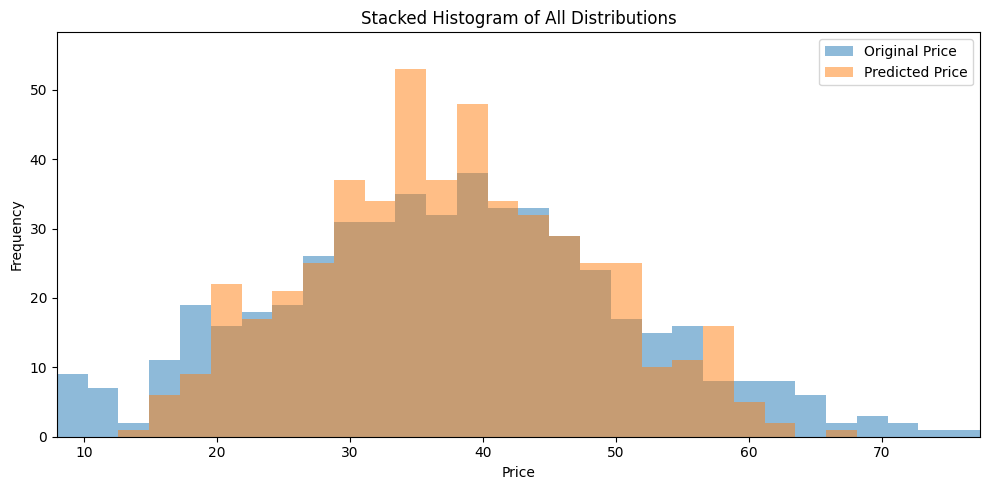

In [37]:
%matplotlib inline
y_pred = candidate_function(X)
plot_histograms([(y, 'Original Price', None), (y_pred, 'Predicted Price', None)], 'Price', stack=True, figsize_per_plot=(10, 5))

<Figure size 640x480 with 0 Axes>

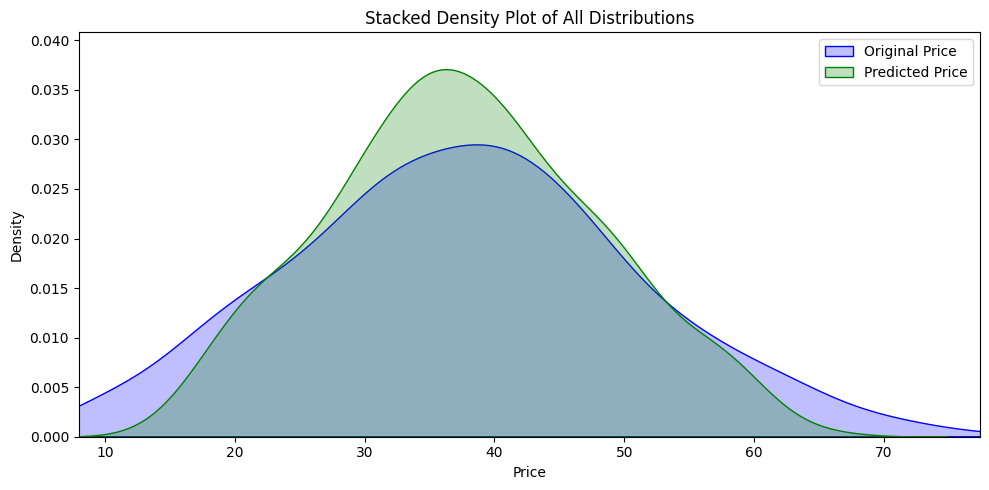

In [21]:
plot_densities([(y, 'Original Price', 'blue'), (y_pred, 'Predicted Price', 'green')], 'Price', stack=True, figsize_per_plot=(10, 5))

In [16]:
orig_residuals = y - y_pred

In [17]:
y_pred_corrected, best_amp, errors, _ = renoise_predictions(y, y_pred, method='stratified', seed=42, clip_lower=0, clip_upper=None, original_residuals=None, tail_replace=True, lower_percentile=50)
# ignore error in orig_residuals after first run

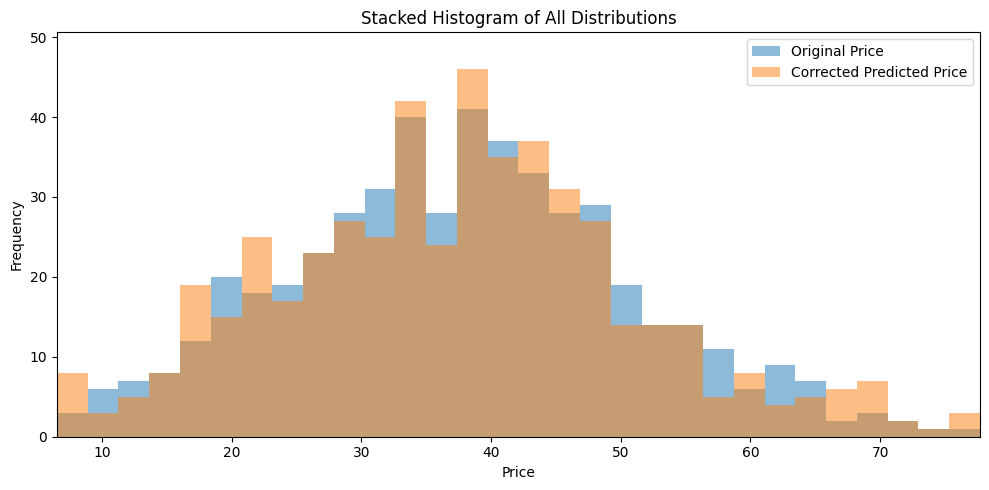

In [24]:
plot_histograms([(y, 'Original Price', None), (y_pred_corrected, 'Corrected Predicted Price', None)], 'Price', stack=True, figsize_per_plot=(10, 5))

<Figure size 640x480 with 0 Axes>

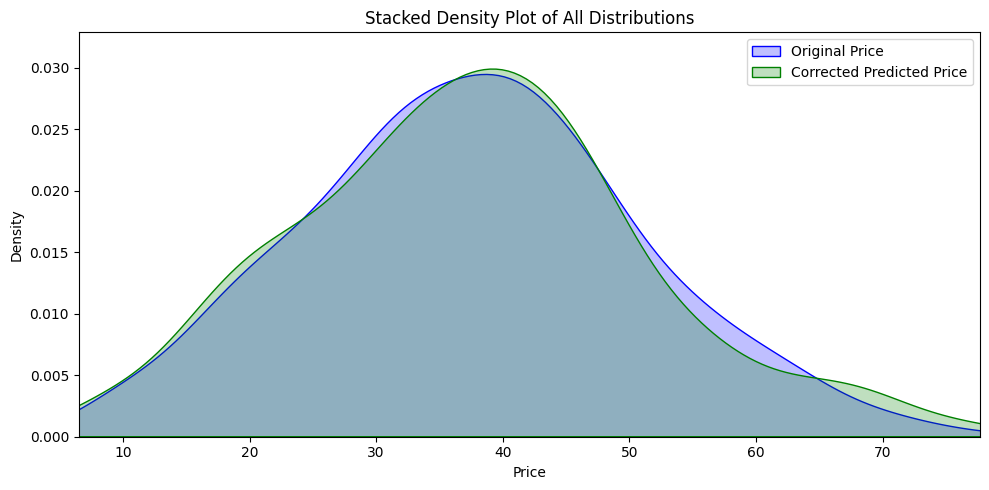

In [25]:
plot_densities([(y, 'Original Price', 'blue'), (y_pred_corrected, 'Corrected Predicted Price', 'green')], 'Price', stack=True, figsize_per_plot=(10, 5))

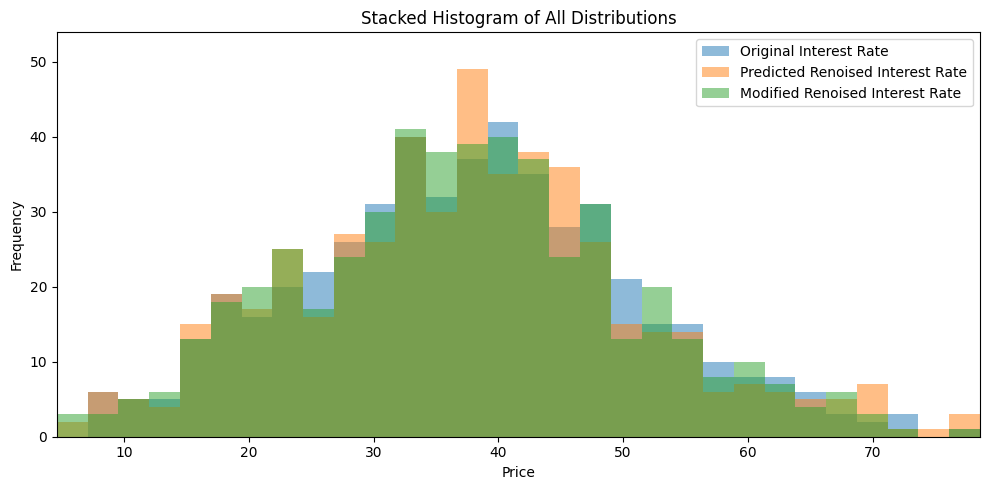

In [38]:
mod_candidate_function = generate_candidate_function("(((log(x0) * 0.023251304) - (x2 + -24.706154)) * -325.6936) - cos((x0 * 297.85324) - 2*x1)")
mod_y_pred = mod_candidate_function(X)
mod_y_pred_corrected, best_amp, errors, _ = renoise_predictions(y, mod_y_pred, method='stratified', amplification_factor=1.0, seed=42, clip_lower=0, clip_upper=None, original_residuals=orig_residuals, tail_replace=True, lower_percentile=50)
# ignore error in orig_residuals after first run
plot_histograms([(y, 'Original Interest Rate', None), (y_pred_corrected, 'Predicted Renoised Interest Rate', None), (mod_y_pred_corrected, 'Modified Renoised Interest Rate', None)], 'Price', stack=True, figsize_per_plot=(10, 5))